In [84]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score ,confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [85]:
import re
import spacy
import gensim
from gensim import corpora
import pickle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text 

import nltk
import operator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import Counter

In [86]:
import matplotlib.style as style
style.use('ggplot') # chosen style
plt.rc('xtick',labelsize=13) # to globally set the tick size
plt.rc('ytick',labelsize=13) # to globally set the tick size
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option("display.max_colwidth", 200)

In [95]:
df_train = pd.read_csv("./data/train.csv",index_col='tweet_id')

In [96]:
df_train.dropna(inplace=True)

In [97]:
negations_dic = {"isnt":"is not", "arent":"are not", "wasnt":"was not", "werent":"were not", 
                "havent":"have not","hasnt":"has not","hadnt":"had not","wont":"will not",
                "wouldnt":"would not", "dont":"do not", "doesnt":"does not","didnt":"did not",
                "cant":"can not","couldnt":"could not","shouldnt":"should not","mightnt":"might not",
                "mustnt":"must not"}

neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

negations_dic.values()

dict_values(['is not', 'are not', 'was not', 'were not', 'have not', 'has not', 'had not', 'will not', 'would not', 'do not', 'does not', 'did not', 'can not', 'could not', 'should not', 'might not', 'must not'])

In [98]:
import string
def clean_text(text):
    #convert the text to lower case
    text = text.lower()
    #remove @mention
    text = re.sub(r'@\w+', '', text)
    #remove Link word
    text = re.sub("{link}",'',text)
    #remove bitly links
    text = re.sub(r"bit.ly/[\w]*",' ',text)
    #remove html tags
    text = re.sub("&[\w;]*",' ',text)
    #remove urls
    text = re.sub(r'http.?://[^\s]+[\s]?',' ',text)
    #remove RT
    text = re.sub(r'(?i)\bRT\b','',text)
    #remove content inside square brackets
    text = re.sub('\[.*?\]', ' ', text)
    #remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #remove digits
    text = re.sub('\d+', ' ',text)
    #remove new line character
    text= re.sub('\n', '', text)
    #retain alphabetts
    text = re.sub("[^a-zA-Z]", " ", text)
    #remove SXSW text
    text = re.sub(r'(?i)\bsxsw\b','',text)
    #convert negation
    text = neg_pattern.sub(lambda x: negations_dic[x.group()],text)
    return text

In [99]:
df_train.tweet = df_train.tweet.apply(lambda x: clean_text(x))

In [100]:
df_train['tweet_len'] = df_train['tweet'].astype(str).apply(len)
df_train['word_count'] = df_train['tweet'].apply(lambda x: len(str(x).split()))

In [101]:
#  custom_stop = ['link','quot','amp','ipad','iphone','google','apple','store','sxswrt','circles','rt','social','sxsw',
#               'austin','android','app','new','will','line','launch','network','today','pop','party','ipad2']

def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list ) and len(word) > 2] 
    return " ".join(clean_words)

In [102]:
df_train.tweet = df_train.tweet.apply(lambda x: remove_stopwords(x))

In [103]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(text):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [104]:
df_train.tweet = df_train.tweet.apply(lambda x: lemmatize_sentence(x))

In [15]:
from nltk import word_tokenize, pos_tag
def nouns(text):
    is_noun = lambda pos: pos == 'NN' 
    tokenized = word_tokenize(text)
    nouns= [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(nouns)

In [16]:
train_noun = pd.DataFrame(df_train.tweet.apply(nouns))
train_noun

tweet
tweet_id                                                                                   
1701                                                  sxswnui apple define language dialect
1851                                     learn google light exception occasion googledoodle
2689                                      inyourface steal show yrs apple school mkt expert
4525                                             iphone app min browse fuckit illmakeitwork
3604                                                           line apple store austin ipad
...                                                                                     ...
3343                                         google plze tammi craziness everything soooooo
5334                                                                             newtwitter
5378                                           lactation room excuse room bring google year
2173                                                         launch ipad get detail edition
3162      fin battle apple goog mobile operator consumer loyalty ton cash bank bankinnovate

[7273 rows x 1 columns]

In [18]:
from wordcloud import WordCloud

(-0.5, 799.5, 499.5, -0.5)

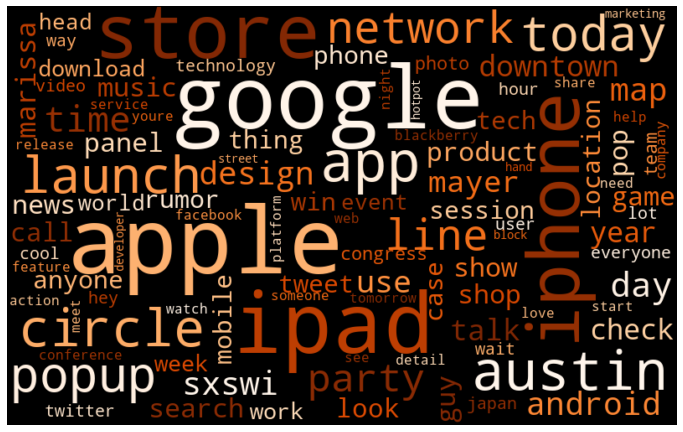

In [28]:
all_words=' '.join(train_noun['tweet'])
#stopwords = ['time','year','call','talk','wait','guy','week','thing','use','hey','need','anyone','youre','see','work','everyone','someone']
# generate wordcloud object
wordcloud=WordCloud( background_color="black", colormap="Oranges_r",collocations=False,width=800,max_words=100,height=500, random_state=21, max_font_size=110).generate(all_words)
# plot wordcloud
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

## Trending HashTags

In [31]:
hash_train =  pd.read_csv("./data/train.csv",index_col='tweet_id')

In [32]:
hash_train.dropna(inplace=True)

In [33]:
hash_train['#tag']=hash_train.tweet.apply(lambda x:','.join(re.findall("#[\w]*", x)))

In [35]:
hash_train['#tag']=hash_train['#tag'].apply(lambda x:','.join(re.sub('[^a-zA-Z]', ' ', x).lower().split()))

In [36]:
hash_train.head()

tweet  sentiment                       #tag
tweet_id                                                                                                                                                                                       
1701                                                            #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller          1         sxswnui,sxsw,apple
1851      Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw          1          googledoodle,sxsw
2689                 one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot;  {link}          2                       sxsw
4525                        This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork          0  sxsw,fuckit,illmakeitwork
3604                                                                        Line outside the Apple store in Austin waiting for the new iPad #SXSW  {link}          1                       sxsw

(-0.5, 799.5, 499.5, -0.5)

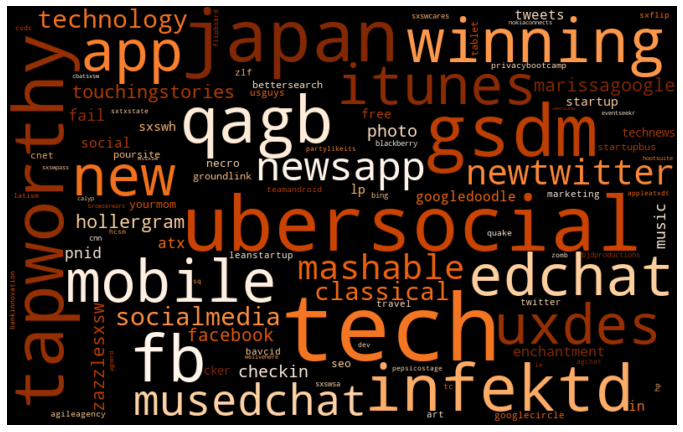

In [41]:
hashtag=','.join(hash_train['#tag'])
stopwords = ['sxsw','SXSW','sxswi','apple','iphone','ipad','google','circles','austin','android']
# generate wordcloud object
wordcloud=WordCloud( background_color="black", colormap="Oranges_r",collocations=False,stopwords=stopwords,width=800,max_words=100,height=500, random_state=21, max_font_size=110).generate(hashtag)
# plot wordcloud
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [42]:
new_data={}
Product_list = ['ipad', 'iphone']
for pList in Product_list:
    for t in range(3):
        if (t == 0) & (pList == 'ipad') :
            new_data['ipad_Negative']=' '.join(df_train[df_train.sentiment.isin([t]) & df_train['tweet'].str.contains('ipad')].tweet)        
        elif (t == 2) & (pList == 'ipad') :
            new_data['ipad_Positive']=' '.join(df_train[df_train.sentiment.isin([t]) & df_train['tweet'].str.contains('ipad')].tweet)
        elif (t == 0) & (pList == 'iphone') :
            new_data['iphone_Negative']=' '.join(df_train[df_train.sentiment.isin([t]) & df_train['tweet'].str.contains('iphone')].tweet)
        elif (t == 2) & (pList == 'iphone') :
            new_data['iphone_Positive']=' '.join(df_train[df_train.sentiment.isin([t]) & df_train['tweet'].str.contains('iphone')].tweet)
      

In [43]:
product_train=pd.DataFrame(new_data.values(),index=new_data.keys(),columns=['tweet'])

In [177]:
product_train.head()

tweet
ipad_Negative    go whole day wout laptop use ipad thing miss ftp cloudapp fast type skype ipad compose tweet acerbic cynical ipad user phone crash dump apps twitterpower imthatgood spent come youve already use ip...
ipad_Positive    think might weekend without see ipad case twice official buying ipad elevate theyre give away ipad box book techenvy bum miss year quarantine kiddie cold garageband ipad comfort brillianti hope pl...
iphone_Negative  iphone app would pretty awesome not crash every min extend browse fuckit illmakeitwork iphone hr tweet riseaustin dead need upgrade plugin station talk mistake make build netflix iphone netflixiph...
iphone_Positive  well yeah music iphone nerd god cute girl everywherei love interactive end music begin awesome new version iphone new web site come want demo meet pls awesome iphone charge locker registrant loung...

In [45]:
product_train.reset_index()

index                                                                                                                                                                                                    tweet
0    ipad_Negative  go whole day wout laptop use ipad thing miss ftp cloudapp fast type skype ipad compose tweet acerbic cynical ipad user phone crash dump apps twitterpower imthatgood spent come youve already use ip...
1    ipad_Positive  think might weekend without see ipad case twice official buying ipad elevate theyre give away ipad box book techenvy bum miss year quarantine kiddie cold garageband ipad comfort brillianti hope pl...
2  iphone_Negative  iphone app would pretty awesome not crash every min extend browse fuckit illmakeitwork iphone hr tweet riseaustin dead need upgrade plugin station talk mistake make build netflix iphone netflixiph...
3  iphone_Positive  well yeah music iphone nerd god cute girl everywherei love interactive end music begin awesome new version iphone new web site come want demo meet pls awesome iphone charge locker registrant loung...

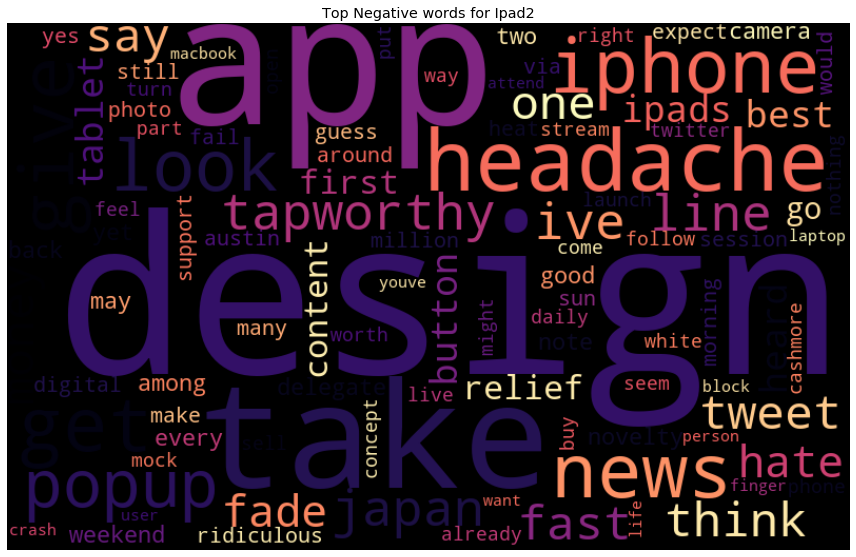

In [56]:
all_words=product_train.tweet[product_train.index[0]]

stopwords = ['sxsw','sxswi','like','not','really','new','day','people','say,''austin','apple','time','year','call','talk','wait','guy','week','thing','use','hey','need','anyone','youre','see','work','everyone','someone','ipad','store']
wordcloud=WordCloud(width=800, height=500,colormap='magma',collocations=False,stopwords=stopwords,random_state=21,max_words=100).generate(all_words)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Negative words for Ipad2')
plt.axis('off')
plt.tight_layout()
plt.show() 

In [72]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from operator import itemgetter
from nltk.stem import WordNetLemmatizer

In [74]:
tokens = nltk.word_tokenize(all_words)
text1 = nltk.Text(tokens)

In [75]:
WNL = nltk.WordNetLemmatizer()

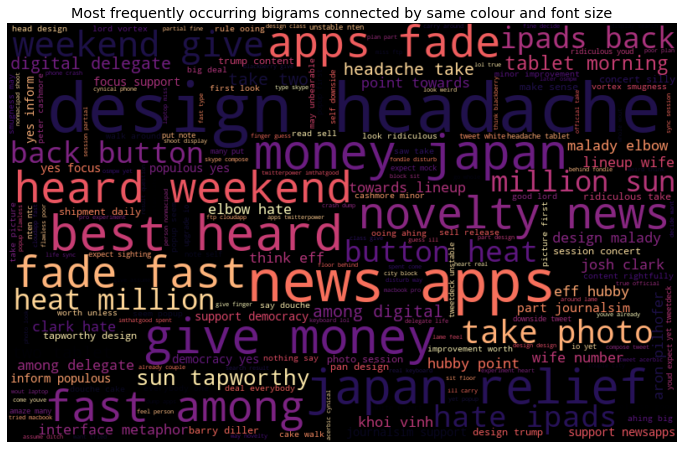

In [83]:
import nltk
from wordcloud import WordCloud, STOPWORDS

WNL = nltk.WordNetLemmatizer()
text = all_words
# Lowercase and tokenize
text = text.lower()
# Remove single quote early since it causes problems with the tokenizer.
# Remove numbers from text
tokens = nltk.word_tokenize(text)
text1 = nltk.Text(tokens)

# Remove extra chars and remove stop words.
text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\\-]", word)) for word in text1]

#set the stopwords list
stopwords_wc = set(STOPWORDS)
custom_stop = ['link','user','like''quot','amp','ipad','ive','iphone','google','apple','store','sxswrt','sxswi','circle','rt','social','sxsw',
               'austin','android','app','new','will','line','launch','network','today','pop','party','ipad2','sxsw','sxswi','like',
               'not','really','new','day','people','say,''austin','apple','time','year','call','talk','wait','guy','week','thing','use','hey',
               'need','anyone','youre','see','work','everyone','someone','ipad','store''circles']  # If you want to remove any particular word form text which does not contribute much in meaning

new_stopwords = stopwords_wc.union(custom_stop)
text_content = [word for word in text_content if word not in new_stopwords]

# After the punctuation above is removed it still leaves empty entries in the list.
text_content = [s for s in text_content if len(s) != 0]

# Best to get the lemmas of each word to reduce the number of similar words
text_content = [WNL.lemmatize(t) for t in text_content]

nltk_tokens = nltk.word_tokenize(text)  
bigrams_list = list(nltk.bigrams(text_content))
dictionary2 = [' '.join(tup) for tup in bigrams_list]


#Using count vectoriser to view the frequency of bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(dictionary2)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

#Generating wordcloud and saving as jpg image
words_dict = dict(words_freq)
wordCloud = WordCloud(width=800, height=500,colormap='magma',stopwords=new_stopwords)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring bigrams connected by same colour and font size')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordCloud.to_file('wordcloud_bigram.jpg')

In [111]:
custom_stop = ['link','user','like''quot','amp','ipad','ive','iphone','google','apple','store','sxswrt','sxswi','circle','rt','social','sxsw',
               'austin','android','app','new','will','line','launch','network','today','pop','party','ipad2','sxsw','sxswi','like',
               'not','really','new','day','people','say,''austin','apple','time','year','call','talk','wait','guy','week','thing','use','hey',
               'need','anyone','youre','see','work','everyone','someone','ipad','store''circles']
stopwords_list = stopwords.words('english') + custom_stop

In [112]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stopwords_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_train['tweet'], 100)


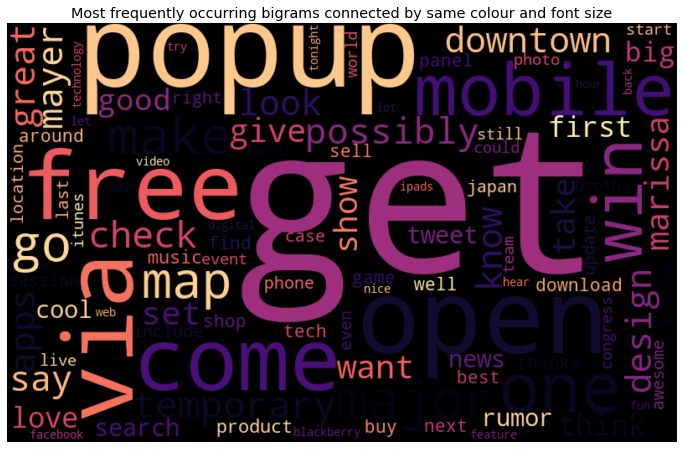

In [113]:
words_dict = dict(common_words)
wordCloud = WordCloud(width=800, height=500,colormap='magma',stopwords=new_stopwords)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring bigrams connected by same colour and font size')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordCloud.to_file('wordcloud_bigram.jpg')

In [119]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),stop_words=stopwords_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_train['tweet'], 100)


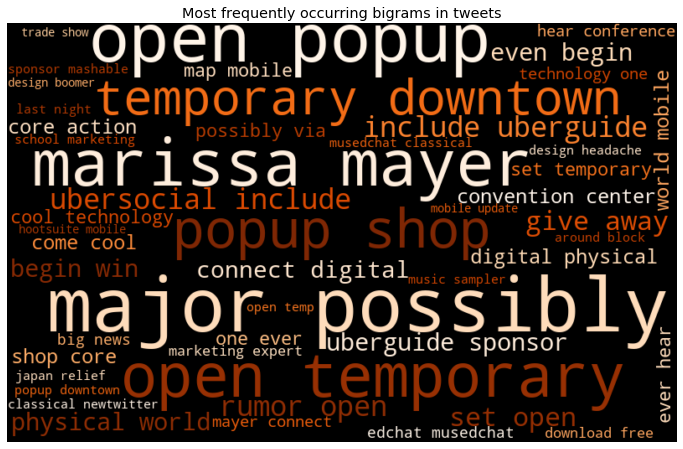

In [123]:
words_dict = dict(common_words)
wordCloud = WordCloud(width=800, height=500,colormap='Oranges',collocations=False,max_words=50,random_state=21)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring bigrams in tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordCloud.to_file('wordcloud_bigram.jpg')

In [124]:
neg_tweets = df_train[df_train.sentiment == 0]

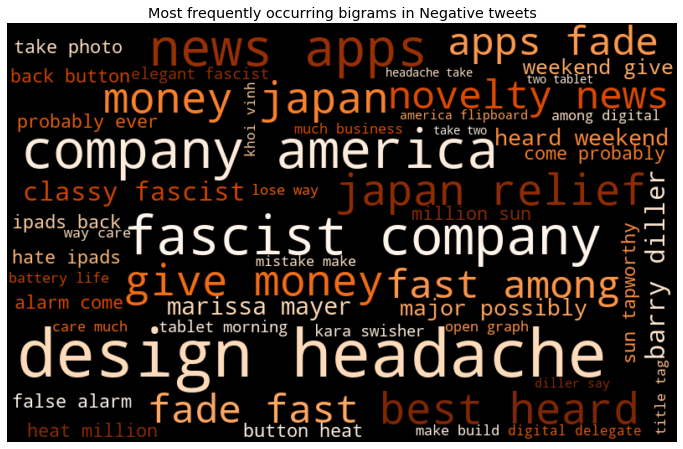

In [130]:
neg_words = get_top_n_bigram(neg_tweets['tweet'], 100)

words_dict = dict(neg_words)
wordCloud = WordCloud(width=800, height=500,colormap='Oranges',collocations=False,max_words=50,random_state=21)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring bigrams in Negative tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordCloud.to_file('wordcloud_bigram.jpg')

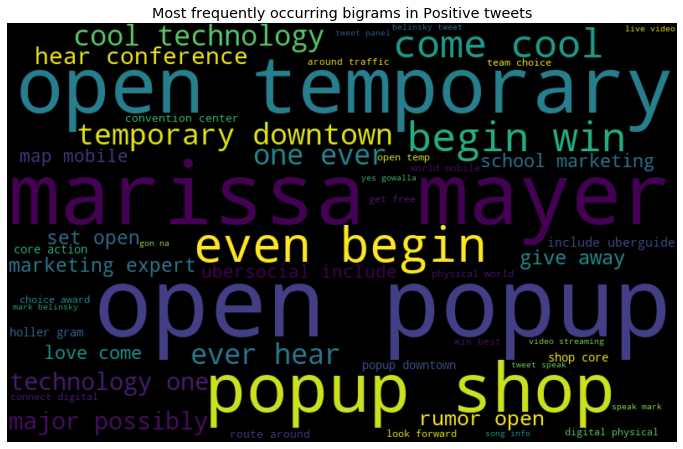

In [137]:
pos_tweets=df_train[df_train.sentiment == 2]
pos_words = get_top_n_bigram(pos_tweets['tweet'], 100)

words_dict = dict(pos_words)
wordCloud = WordCloud(width=800, height=500,collocations=False,max_words=50,random_state=21)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring bigrams in Positive tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordCloud.to_file('wordcloud_bigram.jpg')

In [155]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



## EDA on Trigrams

In [150]:
from nltk.corpus import stopwords

In [151]:
pos_tweets=df_train[df_train.sentiment == 2]

In [152]:
custom_stop = ['link','quot','amp','ipad','iphone','google','apple','store','sxswrt','circles','rt','social','sxsw',
               'austin','android','app','new','will','line','launch','network','today','popup','party','ipad2']

In [153]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english') + custom_stop
    whitelist = ["not","no","n't"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 2] 
    return " ".join(clean_words)

In [154]:
pos_tweets.tweet = pos_tweets.tweet.apply(lambda x: remove_stopwords(x))

In [156]:
pos3_words = get_top_n_trigram(pos_tweets['tweet'], 100)

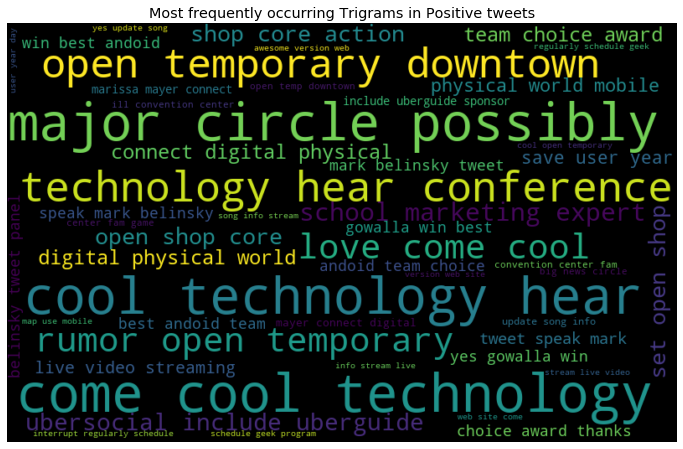

In [157]:
words_dict = dict(pos3_words)
wordCloud = WordCloud(width=800, height=500,collocations=False,max_words=50,random_state=21)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Trigrams in Positive tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative Trigrams

In [158]:
neg_tweets=df_train[df_train.sentiment == 0]

In [159]:
neg_tweets.tweet = neg_tweets.tweet.apply(lambda x: remove_stopwords(x))

In [160]:
neg3_words = get_top_n_trigram(neg_tweets['tweet'], 100)

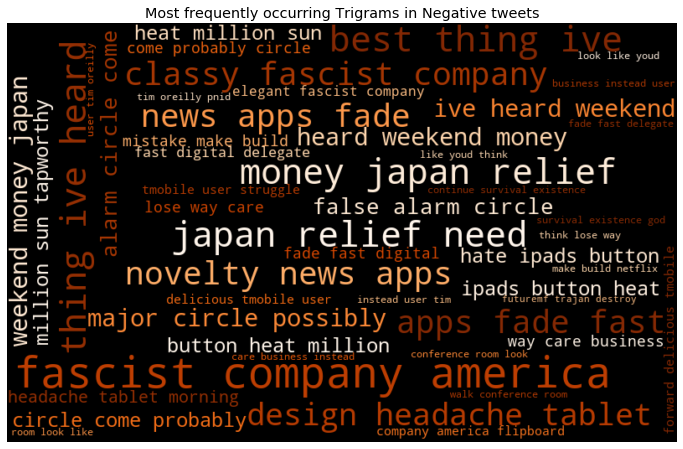

In [175]:
words_dict = dict(neg3_words)
wordCloud = WordCloud(width=800, height=500,collocations=False,max_words=50,random_state=21,colormap='Oranges_r')
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Trigrams in Negative tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

In [ ]:
# all_words=product_train.tweet[product_train.index[0]]

# stopwords = ['sxsw','sxswi','like','not','really','new','day','people','say,''austin','apple','time','year','call','talk','wait','guy','week','thing','use','hey','need','anyone','youre','see','work','everyone','someone','ipad','store']

In [183]:
ipad_tweet = df_train[df_train['tweet'].str.contains('ipad')]

In [196]:
ipad_tweet_pos =ipad_tweet[ipad_tweet.sentiment == 2]
ipad_tweet_neg = ipad_tweet[ipad_tweet.sentiment == 0]
ipad_tweet_pos.tweet = ipad_tweet_pos.tweet.apply(lambda x: remove_stopwords(x))
ipad_tweet_neg.tweet = ipad_tweet_neg.tweet.apply(lambda x: remove_stopwords(x))

In [197]:
ipad_tweet_neg

tweet  sentiment  tweet_len  word_count
tweet_id                                                                                                                    
1178                     whole day wout laptop use thing miss ftp cloudapp fast type skype          0        115          22
2435      compose tweet acerbic cynical user phone crash dump apps twitterpower imthatgood          0        128          22
180                                    spent come youve already use wait couple city block          0        100          18
4454                                               sit floor behind guy fondle disturb way          0         88          17
3136                                            novelty news apps fade fast among delegate          0         59          10
...                                                                                    ...        ...        ...         ...
2591                         srsly love promo srsly hate excludes esp since insists disney          0         88          16
8649                                                            wow suck rebecca black fab          0         38           7
4572                                                                    internet blur fade          0         44           7
5315                rumor mill camera slightly thinner rare earth case still smudgy screen          0        119          18
268                course build temp texas understand concept corral cattle pickmeupanipad          0        120          19

[152 rows x 4 columns]

In [208]:
ipad_pos_3gram= get_top_n_trigram(ipad_tweet_pos['tweet'], 20)
ipad_neg_3gram = get_top_n_trigram(ipad_tweet_neg['tweet'], 20)

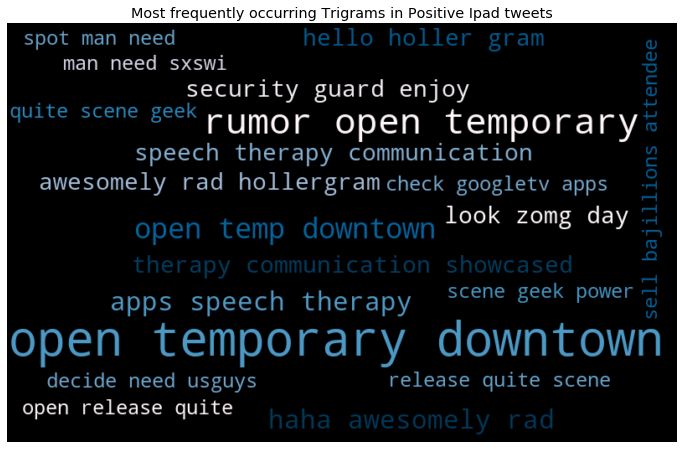

In [209]:
words_dict = dict(ipad_pos_3gram)
wordCloud = WordCloud(width=800, height=500,max_words=50,random_state=21,colormap='PuBu_r',max_font_size=80)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Trigrams in Positive Ipad tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

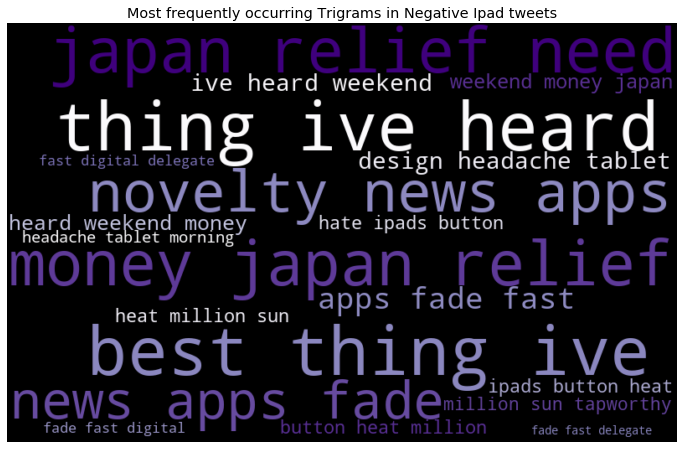

In [210]:
words_dict = dict(ipad_neg_3gram)
wordCloud = WordCloud(width=800, height=500,max_words=50,random_state=21,colormap='Purples_r',max_font_size=80)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Trigrams in Negative Ipad tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [211]:
ipad_look = ipad_tweet[(ipad_tweet['tweet'].str.contains('look')) | (ipad_tweet['tweet'].str.contains('case'))]

In [231]:
stopwords_list = ['zomg','day','saw','look']

In [232]:
ipad_look['tweet']=ipad_look.tweet.apply(lambda x:nltk.word_tokenize(x))
ipad_look['tweet']=ipad_look['tweet'].apply(lambda row:[word for word in row if word not in stopwords_list])
ipad_look['tweet']=ipad_look['tweet'].apply(lambda x: ' '.join(x))

In [233]:
ipad_look_pos = ipad_look[ipad_look['sentiment']==2]
ipad_look_neg = ipad_look[ipad_look['sentiment']==0]


In [234]:
ipad_look_pos_3gram= get_top_n_trigram(ipad_look_pos['tweet'], 20)
ipad_look_neg_3gram = get_top_n_trigram(ipad_look_neg['tweet'], 20)

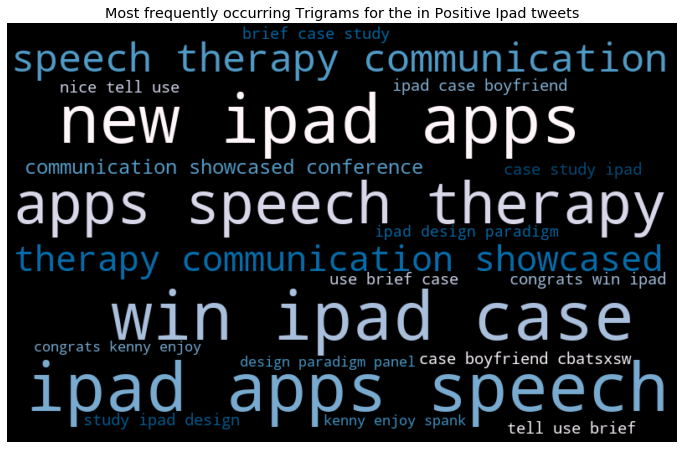

In [235]:
words_dict = dict(ipad_look_pos_3gram)
wordCloud = WordCloud(width=800, height=500,max_words=50,random_state=21,colormap='PuBu_r',max_font_size=80)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Trigrams for the in Positive Ipad tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

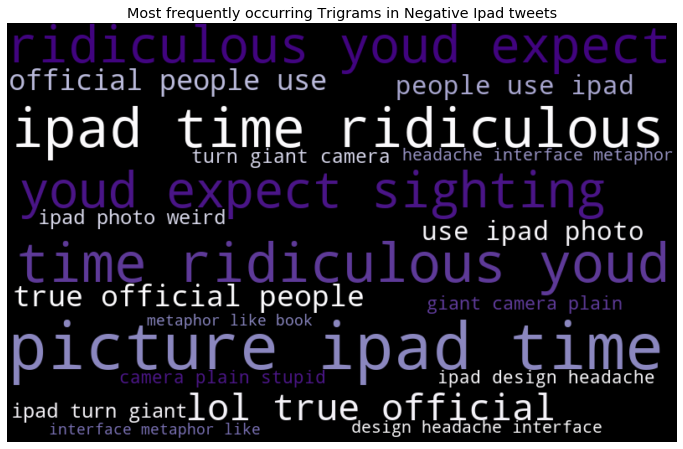

In [236]:
words_dict = dict(ipad_look_neg_3gram)
wordCloud = WordCloud(width=800, height=500,max_words=50,random_state=21,colormap='Purples_r',max_font_size=80)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Trigrams in Negative Ipad tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [237]:
ipad_look_bigram_pos = get_top_n_bigram(ipad_look_pos['tweet'], 20)
ipad_look_bigram_neg = get_top_n_bigram(ipad_look_neg['tweet'], 20)

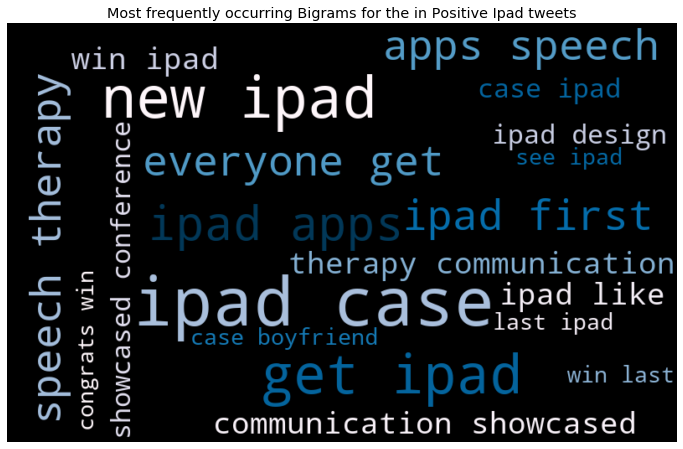

In [238]:
words_dict = dict(ipad_look_bigram_pos)
wordCloud = WordCloud(width=800, height=500,max_words=50,random_state=21,colormap='PuBu_r',max_font_size=80)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Bigrams for the in Positive Ipad tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

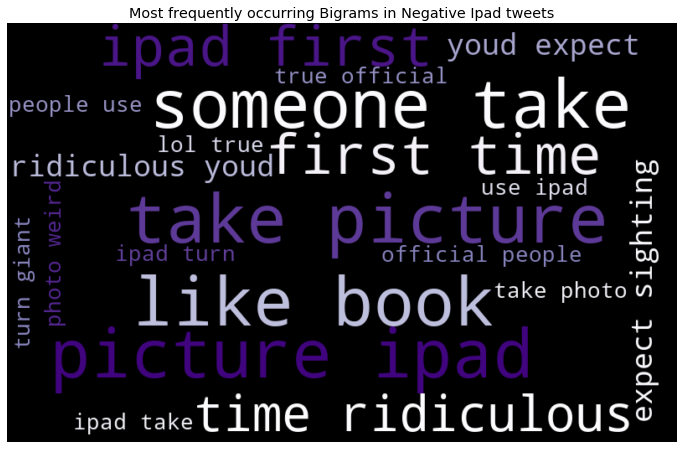

In [239]:
words_dict = dict(ipad_look_bigram_neg)
wordCloud = WordCloud(width=800, height=500,max_words=50,random_state=21,colormap='Purples_r',max_font_size=80)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Bigrams in Negative Ipad tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [240]:
iphone_tweet = df_train[df_train['tweet'].str.contains('iphone')]

In [242]:
iphn_tweet_pos =iphone_tweet[iphone_tweet.sentiment == 2]
iphn_tweet_neg = iphone_tweet[iphone_tweet.sentiment == 0]
iphn_tweet_pos.tweet = iphn_tweet_pos.tweet.apply(lambda x: remove_stopwords(x))
iphn_tweet_neg.tweet = iphn_tweet_neg.tweet.apply(lambda x: remove_stopwords(x))

In [243]:
iphone_pos_3gram= get_top_n_trigram(iphn_tweet_pos['tweet'], 25)
iphone_neg_3gram = get_top_n_trigram(iphn_tweet_neg['tweet'], 25)

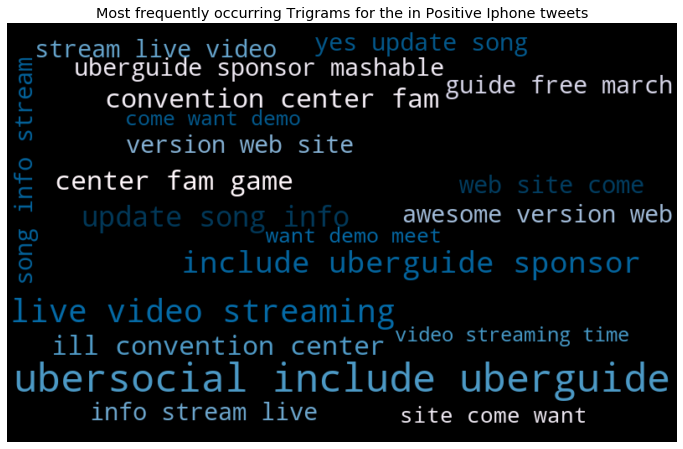

In [247]:
words_dict = dict(iphone_pos_3gram)
wordCloud = WordCloud(width=800, height=500,max_words=50,random_state=21,colormap='PuBu_r',max_font_size=80)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Trigrams for the in Positive Iphone tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

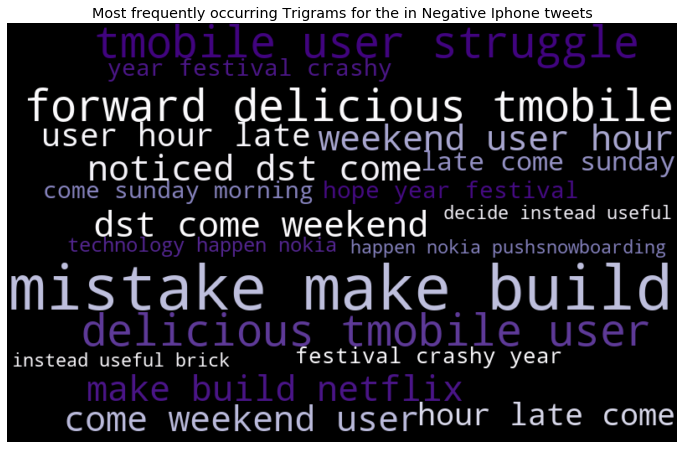

In [248]:
words_dict = dict(iphone_neg_3gram)
wordCloud = WordCloud(width=800, height=500,max_words=50,random_state=21,colormap='Purples_r',max_font_size=80)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Trigrams for the in Negative Iphone tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [254]:
iphone_pos_bigram= get_top_n_bigram(iphn_tweet_pos['tweet'], 20)
iphone_neg_bigram = get_top_n_bigram(iphn_tweet_neg['tweet'], 20)

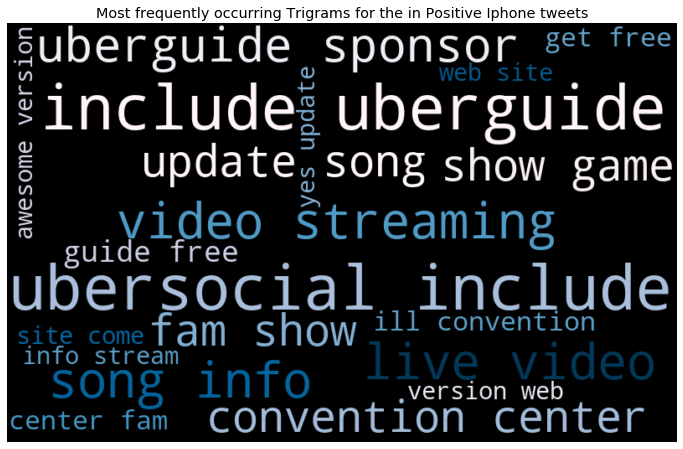

In [255]:
words_dict = dict(iphone_pos_bigram)
wordCloud = WordCloud(width=800, height=500,max_words=50,random_state=21,colormap='PuBu_r',max_font_size=80)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Trigrams for the in Positive Iphone tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

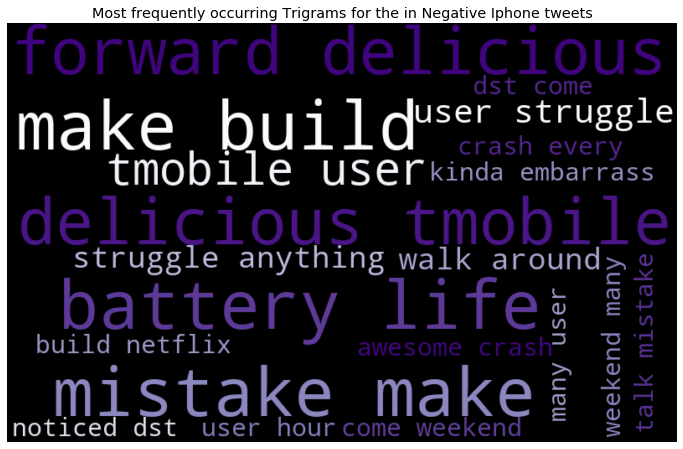

In [256]:
words_dict = dict(iphone_neg_bigram)
wordCloud = WordCloud(width=800, height=500,max_words=50,random_state=21,colormap='Purples_r',max_font_size=80)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(12,12))
plt.title('Most frequently occurring Trigrams for the in Negative Iphone tweets')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [258]:
iphone_tweet_bar = iphone_tweet[(iphone_tweet['sentiment'] == 0) | (iphone_tweet['sentiment'] == 2)]

In [259]:
iphone_tweet_bar.shape

(574, 4)

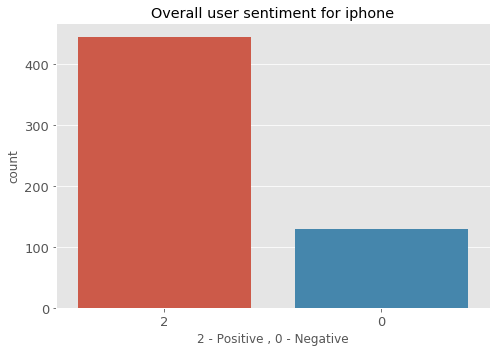

In [268]:
plt.figure(figsize=(7,5))
sns.countplot(iphone_tweet_bar['sentiment'],order = iphone_tweet_bar['sentiment'].value_counts().index)
plt.title('Overall user sentiment for iphone')
plt.xlabel("2 - Positive , 0 - Negative")
plt.tight_layout()
plt.show()

In [262]:
ipad_tweet_bar = ipad_tweet[(ipad_tweet['sentiment'] == 0) | (ipad_tweet['sentiment'] == 2)]

In [263]:
ipad_tweet_bar.shape

(1099, 4)

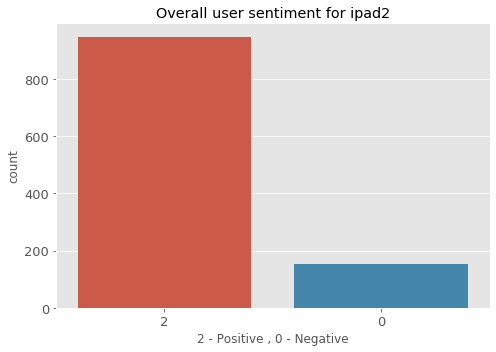

In [269]:
plt.figure(figsize=(7,5))
sns.countplot(ipad_tweet_bar['sentiment'],order = ipad_tweet_bar['sentiment'].value_counts().index)
plt.title('Overall user sentiment for ipad2')
plt.xlabel("2 - Positive , 0 - Negative")
plt.tight_layout()
plt.show()